# Khóa học VIA - Bài học: Lọc ảnh

<img width="120px" src="https://via.makerviet.org/media/via-logo.png">

**Website:** https://via.makerviet.org/

Nội dung khóa học này được tạo và phân phối miễn phí cho người học bởi các thành viên của dự án VIA. Toàn bộ bản quyền các nội dung trong khóa học thuộc về [MakerHanoi](https://www.facebook.com/makerhanoi/).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/makerhanoi/via-course-ai/blob/master/notebooks/03-Loc-anh.ipynb)|


## 1. Nguyên lý chung

Nguyên tắc chung của các phương pháp lọc là cho ma trận ảnh nhân với một ma trận lọc (kernel). Ma trận lọc (kernel) còn có thể được gọi là cửa sổ chập (trong phép nhân chập), cửa sổ lọc, mặt nạ,… Việc nhân ảnh với ma trận lọc giống như việc trượt ma trận lọc theo hàng trên ảnh và nhân với từng vùng của ảnh, cộng các kết quả lại tạo thành kết quả của điểm ảnh trung tâm.

![image](padding_strides.gif)

**Minh họa việc nhân ma trận ảnh. Hình ảnh được lấy từ <https://github.com/vdumoulin/conv_arithmetic>**

![](https://aicurious.io/posts/2018-09-29-loc-anh-image-filtering/SpatialFiltering-234.jpg)

Trong hình minh họa trên, chúng là có ảnh đầu vào I nằm bên trái, ảnh đầu ra O nằm bên phải. Khi ma trận lọc có kích thước 3x3, mỗi điểm ảnh trên hình ảnh đầu ra O được tạo thành từ vùng 3x3 = 9 ô trên ảnh đầu vào I, với các hệ số khác nhau.

Trên thực tế, chúng ta sẽ thấy có 2 phép lọc ảnh là tương quan (correlation) và tích chập (convolution). Với phép tương quan, ma trận lọc sẽ được trượt đi và nhân với từng vùng của ảnh như trên. Tuy nhiên với phép tích chập, ma trận lọc sẽ được xoay 180 độ (theo cả chiều ngang và dọc) trước khi thực hiện nhân. 2 phép toán này là tương đương khi ma trận lọc đối xứng.


Lọc ảnh (hoặc làm mịn ảnh, làm mượt ảnh, lọc biên) là một bước rất quan trọng trong xử lý ảnh. Lọc ảnh thực tế có rất nhiều tác dụng như loại bỏ nhiễu, làm rõ biên đối tượng. Phần này sẽ giới thiệu đến các bạn một số nguyên lý chung và một vài bộ lọc hay dùng.

Nội dung được xây dựng dựa trên bài viết [Lọc ảnh - Blog AICurious.io](https://aicurious.io/posts/2018-09-29-loc-anh-image-filtering/).

In [ ]:
# Import các thư viện cần thiết
from google.colab.patches import cv2_imshow # Dùng để hiện ảnh trên Colab
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
!wget https://aicurious.io/files/2018-09-29/ImageFiltering.zip && unzip ImageFiltering.zip -d .

--2021-10-23 13:37:45--  https://aicurious.io/files/2018-09-29/ImageFiltering.zip
Resolving aicurious.io (aicurious.io)... 138.68.61.186, 138.68.234.180, 2600:1f1c:471:9d01:205d:4ea3:d46b:9cc6, ...
Connecting to aicurious.io (aicurious.io)|138.68.61.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 673038 (657K) [application/zip]
Saving to: ‘ImageFiltering.zip.1’

ImageFiltering.zip. 100%[===================>] 657.26K  --.-KB/s    in 0.1s    

2021-10-23 13:37:46 (4.62 MB/s) - ‘ImageFiltering.zip.1’ saved [673038/673038]

Archive:  ImageFiltering.zip
replace ./average_filter.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./average_filter.py     
  inflating: ./average_filter_filter2D.py  
  inflating: ./bilateral_filter.py   
  inflating: ./create_noise.py       
  inflating: ./gaussian_filter.py    
  inflating: ./gaussian_filter_wood.py  
  inflating: ./median_filter.py      
  inflating: ./noisywood.py          
  inflating: ./rose.jpg          

## 2. Làm mịn ảnh: Lọc trung bình

Trong nhiều trường hợp, hình ảnh đầu vào có nhiều nhiễu, chúng ta phải lọc, hay làm mịn để loại bỏ hoặc giảm nhiễu trước khi đưa vào các bước tiếp theo. Bộ lọc trung bình là một trong những bộ lọc được sử dụng để làm việc này. Ma trận lọc trung bình có dạng như sau:
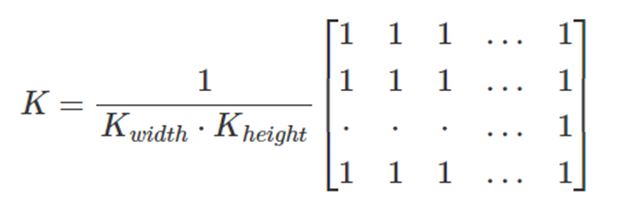


Có thể hiểu đơn giản, mỗi điểm ảnh trên ảnh đầu ra O sẽ là trung bình cộng của một vùng đúng bằng kích thước của ma trận lọc. Nếu ma trận lọc có kích thước 5x5, việc áp dụng bộ lọc trung bình sẽ tương đương với việc tính toán trung bình của từng ô 5x5 trong ảnh và viết vào 1 ô trong ảnh mới. Sau đó, chúng ta lại xét vùng 5x5 tiếp theo ngay bên cạnh, có chồng lấn với vùng cũ. Ở hình động bên dưới, ảnh màu xanh lục chính là ảnh thu được khi trượt các cửa sổ 3x3 trên ảnh màu xanh lam. Trên thực tế, ảnh thu được có thể nhỏ hơn ảnh đầu vào. Để đảm bảo việc này không xảy ra, người ta thường mở rộng ảnh cũ bằng cách chèn các vùng màu (padding) vào xung quanh ảnh cũ. Việc này có thể giúp ảnh mới thu được có kích thước đúng bằng ảnh ban đầu.

![image](padding_strides.gif)
	
Thư viện OpenCV cũng hỗ trợ việc lọc ảnh sử dụng bộ lọc trung bình hết sức dễ dàng với hàm `cv.blur()`. Đoạn mã nguồn bên dưới sẽ thực hiện đọc lên 2 hình ảnh. Hình thứ nhất là `rose_gauss.jpg`, là hình một bông hoa hồng bị nhiễu Gaussian, loại nhiễu ngẫu nhiên gây ra bởi môi trường, chất lượng ống kính, cảm biến hoặc điều kiện ánh sáng không tốt khi chụp ảnh. Hình thứ 2 là `rose_salt_and_pepper.jpg`, cũng là hình ảnh bông hoa đó, nhưng bị nhiễu muối tiêu. Nhiễu muối tiêu có đặc điểm phân bố rải rác thành các đốm nhỏ li ti như muối tiêu. Chúng ta sẽ dùng thử bộ lọc trung bình trong OpenCV để lọc nhiễu cho các ảnh này.


Ảnh ban đầu


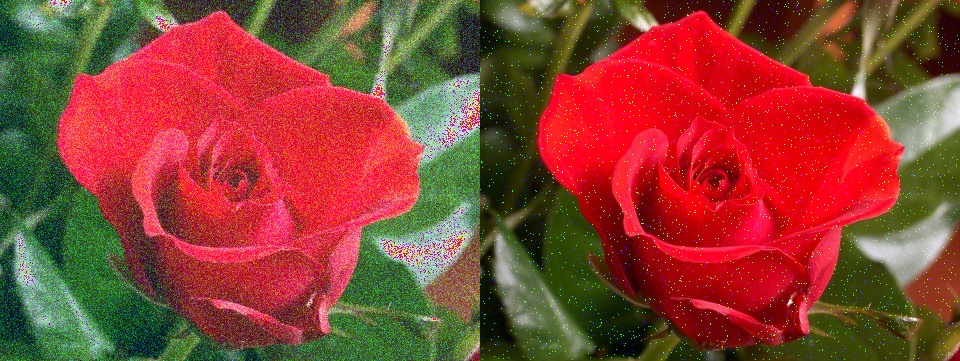

Ảnh sau khi lọc


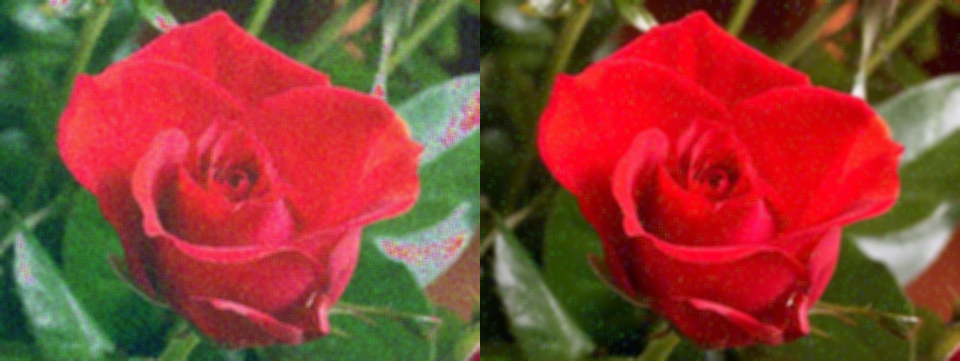

In [ ]:
# Đọc ảnh
img = cv2.imread('rose_gauss.jpg')
img2 = cv2.imread('rose_salt_and_pepper.jpg')

# Áp dụng bộ lọc với ma trận lọc 5x5
blur = cv2.blur(img,(5,5))
blur2 = cv2.blur(img2,(5,5))

# Hiển thị hình ảnh
print("Ảnh ban đầu")
cv2_imshow(np.hstack([img, img2]))
print("Ảnh sau khi lọc")
cv2_imshow(np.hstack([blur, blur2]))

So sánh các ảnh trước và sau khi lọc, ta có thể thấy nhiễu đã được giảm phần nào nhờ bộ lọc trung bình.

## 3. Làm mịn ảnh: Lọc Gaussian

Bộ lọc trung bình có 1 vấn đề là giá trị 1 điểm ảnh có tọa độ (x1, y1) trong ảnh đầu ra sẽ phụ thuộc vào một vùng các điểm ảnh xung quanh đó trong ảnh đầu vào với trọng số bằng nhau. Như vậy bất kể các điểm ảnh ở xa hay ở gần vị trí trung tâm (x1, y1) đều sẽ đóng góp vào giá trị điểm ảnh mới với tỷ lệ như nhau, chỉ cần chúng nằm trong cửa sổ lọc. Ý tưởng của bộ lọc Gaussian là đánh trọng số lại tỷ lệ này, sao cho các điểm ảnh ở càng gần (x1, y1) sẽ chiếm tỷ lệ cao hơn khi tính toán, quyết định đến giá trị của điểm ảnh đầu ra nhiều hơn. Cách làm này cũng phù hợp hơn với logic. Trên thực tế, bộ lọc Gaussian được tạo ra nhờ phân phối chuẩn trong xác suất thống kê. Ví dụ bộ lọc Gaussian 5x5 sẽ có dạng như sau:

In [ ]:
kernel = cv2.getGaussianKernel(5, -1) # Tìm ma trận lọc Gaussian 1D
kernel_2D = kernel @ kernel.transpose() # Tìm ma trận lọc Gaussian 2D bằng cách nhân 2 ma trận 1D
print(kernel_2D)

[[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]]


Ảnh ban đầu


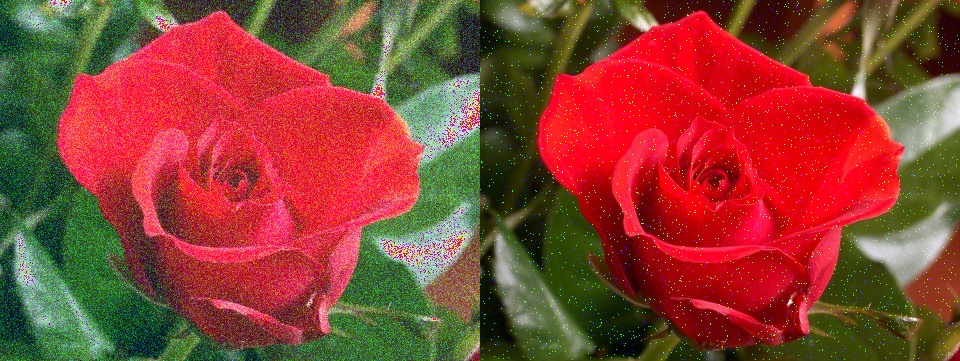

Ảnh sau khi lọc


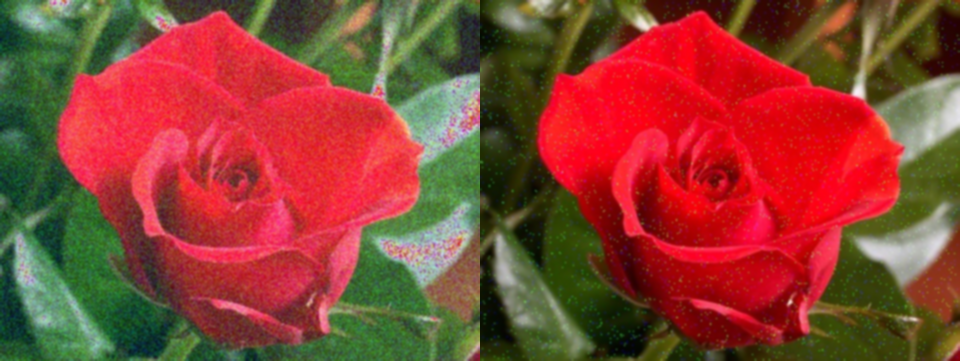

In [ ]:
# Đọc ảnh
img = cv2.imread('rose_gauss.jpg')
img2 = cv2.imread('rose_salt_and_pepper.jpg')

# Áp dụng bộ lọc với ma trận lọc 5x5
gauss_blur = cv2.GaussianBlur(img, (5,5), 0)
gauss_blur2 = cv2.GaussianBlur(img2, (5,5), 0)

# Hiển thị hình ảnh
print("Ảnh ban đầu")
cv2_imshow(np.hstack([img, img2]))
print("Ảnh sau khi lọc")
cv2_imshow(np.hstack([gauss_blur, gauss_blur2]))

Có thể thấy, với cùng một kích thước bộ lọc, bộ lọc Gaussian sẽ giữ lại được các chi tiết tốt hơn bộ lọc trung bình.

## 4. Làm mịn ảnh: Bộ lọc trung vị

Phép lọc trung vị sẽ tính và lấy trung vị của các giá trị điểm ảnh trong vùng cửa sổ lọc để làm giá trị điểm ảnh đầu ra, có thể thực hiện với 2 bước như sau:

-	Sắp xếp các giá trị điểm ảnh theo thứ tự tăng dần.
-	Lấy giá trị điểm ảnh nằm giữa.

Trong OpenCV, đối với các ảnh có nhiều kênh màu, như ảnh RGB, HSV, thì các kênh màu được xử lý riêng biệt, sau đó sẽ gộp lại thành ảnh mới. Bộ lọc trung vị luôn lấy một giá trị điểm ảnh có sẵn trong ảnh gốc để đưa vào ảnh mới, thay vì tính toán để tạo ra một giá trị mới như các bộ lọc được giới thiệu trước đó. Bộ lọc này có khả năng loại bỏ nhiễu muối tiêu rất tốt. Trong OpenCV, ta có thể dùng hàm `cv2.medianBlur()` cho bộ lọc này. Dưới đây là ví dụ thực hiện.




Ảnh ban đầu


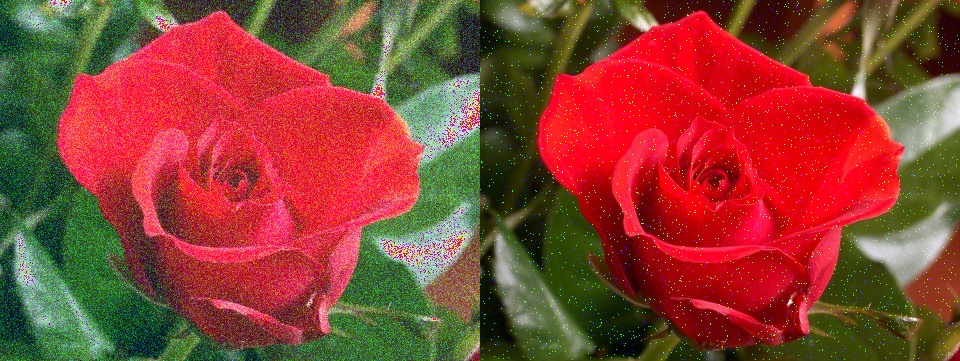

Ảnh sau khi lọc


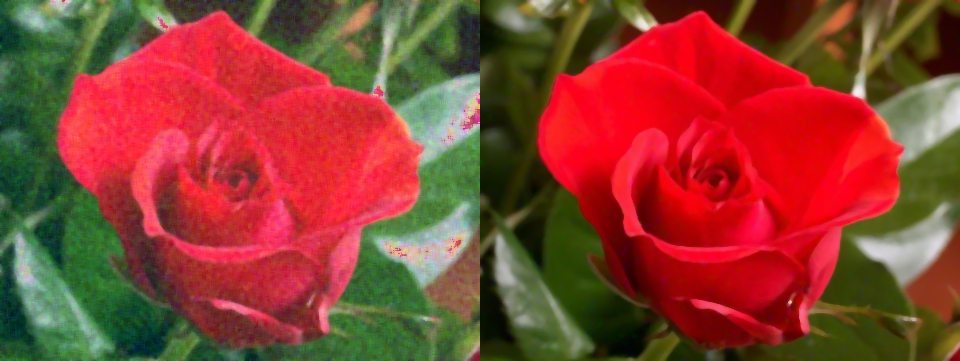

In [ ]:
# Đọc ảnh
img = cv2.imread('rose_gauss.jpg')
img2 = cv2.imread('rose_salt_and_pepper.jpg')

# Áp dụng bộ lọc với ma trận lọc 5x5
median_blur = cv2.medianBlur(img, 5)
median_blur2 = cv2.medianBlur(img2, 5)

# Hiển thị hình ảnh
print("Ảnh ban đầu")
cv2_imshow(np.hstack([img, img2]))
print("Ảnh sau khi lọc")
cv2_imshow(np.hstack([median_blur, median_blur2]))

## 5. Làm mịn ảnh: Bộ lọc Bilateral

Quan sát lại các hình ảnh kết quả của 3 bộ lọc trước, các bạn có thể thấy ngoài việc lọc nhiễu, các bộ lọc gây ra tác dụng phụ là làm mờ các cạnh (các biên, các đường nét) trong ảnh. Bộ lọc trung bình tính toán giá trị điểm ảnh mới dựa trên các điểm ảnh cũ với trọng số như sau, không quan tâm đến màu sắc và vị trí tương đổi của các điểm ảnh đó với nhau. Bộ lọc Gaussian đã có thể đặt các trọng số dựa theo vị trí: điểm ảnh nào càng ở gần sẽ quyết định nhiều hơn đến giá trị điểm ảnh mới. Tuy nhiên nó cũng chưa quan tâm đến các giá trị màu sắc, và việc điểm ảnh có nằm tại các cạnh trong ảnh không, vì thế cũng sẽ làm mờ các cạnh. Bộ lọc Bilateral sử dụng một bộ lọc Gaussian với khoảng cách đến điểm trung tâm, đảm bảo việc đánh trọng số theo khoảng cách. Đồng thời, nó sử dụng thêm một hàm Gaussian cho mức xám, đánh trọng số cho các mức xám để đảm bảo chỉ các điểm ảnh có mức xám tương đồng với điểm ảnh trung tâm sẽ đóng góp chính vào quá trình tính toán điểm ảnh mới. Tại các biên trong ảnh, mức xám có sự thay đổi rất rõ ràng, vì thế việc đánh trọng số cho theo sự thay đổi mức xám sẽ đảm bảo các vị trí điểm ảnh có mức xám khác nhau không ảnh hưởng đến nhau, vì thế sẽ không làm mờ các cạnh trong ảnh. Chúng ta có thể sử dụng bộ lọc Bilateral thông qua hàm `cv2.bilateralFilter()`, với các tham số:

-	**d**: Bán kính xung quanh điểm ảnh sẽ được sử dụng để tính toán.
-	**sigmaColor**: Giá trị lọc cho không gian màu sắc. Giá trị này càng lớn, chúng ta sẽ càng loại bỏ được các nhiễu màu sắc trong ảnh, có nghĩa là sẽ càng nhiều điểm ảnh có màu sắc tương đồng trong hình ảnh đầu ra.
-	**sigmaSpace**: Giá trị lọc cho không gian khoảng cách. Giá trị này càng lớn, các điểm ảnh ở xa càng có cơ hội đóng góp nhiều hơn vào giá trị điểm ảnh mới, với điều kiện chúng đủ tương đồng về màu sắc (sigmaColor). Nếu ta truyền giá trị d = 0 vào, d sẽ được tính toán tỷ lệ thuận với sigmaSpace.

Các giá trị sigma sẽ có tác động nhỏ nếu giá trị của chúng thấp (<10). Nếu các giá trị sigma được đặt cao (>150), bộ lọc sẽ có tác động rất mạnh, tạo ra ảnh mới giống như ảnh hoạt hình. Đọc thêm về bộ lọc Bilateral tại đây: https://www.geeksforgeeks.org/python-bilateral-filtering/.

Sau đây là ví dụ về việc sử dụng bộ lọc Bilateral.


Ảnh ban đầu


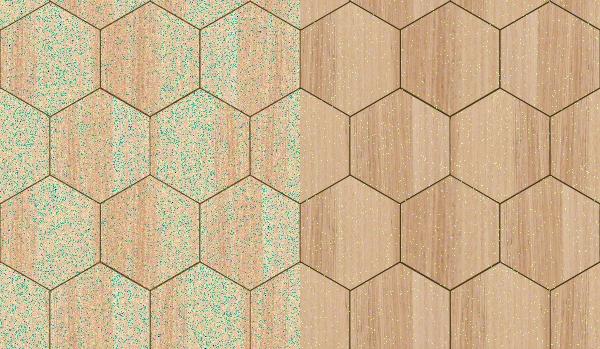

Ảnh sau khi lọc


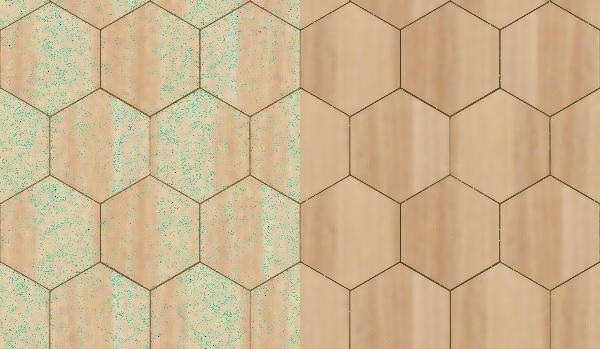

In [ ]:
# Đọc ảnh
img = cv2.imread('wood_gauss.jpg')
img2 = cv2.imread('wood_salt_and_pepper.jpg')

# Áp dụng bộ lọc Bilateral
d = 9
sigmaColor = 100
sigmaSpace = 50
bilateral_blur = cv2.bilateralFilter(img, d, sigmaColor, sigmaSpace)
bilateral_blur2 = cv2.bilateralFilter(img2, d, sigmaColor, sigmaSpace)

# Hiển thị hình ảnh
print("Ảnh ban đầu")
cv2_imshow(np.hstack([img, img2]))
print("Ảnh sau khi lọc")
cv2_imshow(np.hstack([bilateral_blur, bilateral_blur2]))

Ảnh ban đầu


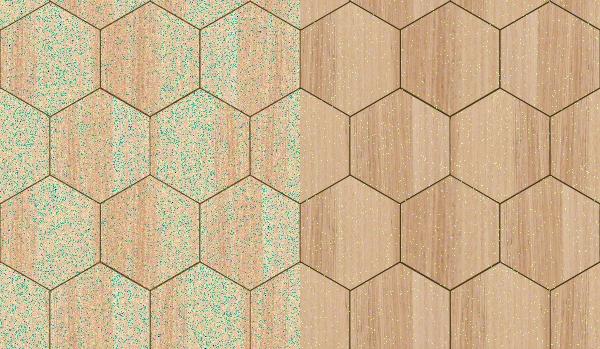

Ảnh sau khi lọc


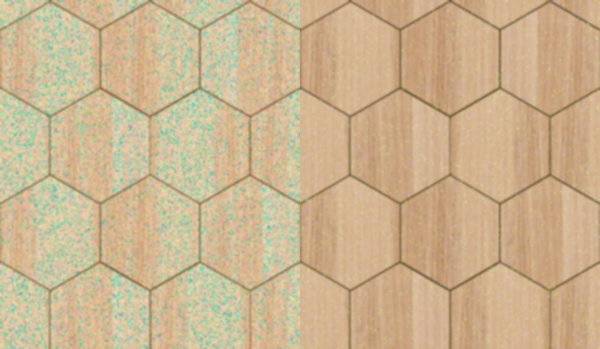

In [ ]:
# Đọc ảnh
img = cv2.imread('wood_gauss.jpg')
img2 = cv2.imread('wood_salt_and_pepper.jpg')

# Áp dụng bộ lọc với ma trận lọc 5x5
gauss_blur = cv2.GaussianBlur(img, (5,5), 0)
gauss_blur2 = cv2.GaussianBlur(img2, (5,5), 0)

# Hiển thị hình ảnh
print("Ảnh ban đầu")
cv2_imshow(np.hstack([img, img2]))
print("Ảnh sau khi lọc")
cv2_imshow(np.hstack([gauss_blur, gauss_blur2]))

Có thể thấy nhiễu trong ảnh được lọc khá tốt, trong khi các đường biên được bảo toàn rất tốt. So sánh với kết quả từ bộ lọc Gaussian 5x5 ở hình sau đó, ta thấy việc bảo toàn biên của bộ lọc Bilateral tốt hơn nhiều. Tuy vậy nhược điểm của bộ lọc Bilateral là tốc độ. Bộ lọc này chạy chậm hơn rất nhiều so với các bộ lọc trước đó trong trường hợp các giá trị sigma lớn. Vì thế, chúng ta cần tính đến yếu tố thời gian chạy khi có ý định sử dụng bộ lọc Bilateral cho các bài toán cần xử lý nhanh. Các bạn có thể thử thay đổi các giá trị **d**, **sigmaColor**, **sigmaSpace** để thấy được sự thay đổi về kết quả và thời gian xử lý.

## 6. Lọc Sobel

Các bộ lọc cũng được sử dụng để tìm cạnh, hay các đường biên, đường nét trong ảnh. Một trong các bộ lọc phổ biến nhất cho mục đích này là bộ lọc Sobel. Bộ lọc này hoạt động với ảnh xám. 

Mối quen hệ giữa đạo hàm và các đương biên: Xét vị dụ sau: Ta có một hình ảnh (1) với hai biên đã được làm mờ. Hình (2) cho thấy mức xám tại đường quét màu đỏ của ảnh. Dễ dàng nhận thấy các đường biên ảnh chính là 2 vùng có sự thay đổi đột ngột về mức xám. Để xác định những sự thay đổi này, ta sử dụng đạo hàm của dải mức xám và tìm các cực trị (địa phương) trên đó. Có thể thấy rõ mối liên hệ giữa các cực trị địa phương của đạo hàm với các biên trong ảnh.


![](https://aicurious.io/posts/2018-09-29-loc-anh-image-filtering/bien-anh-va-cuc-tri.png)

**Liên hệ giữa cực trị địa phương và các đường biên trong ảnh. Nguồn: Blog AICurious.io.**

Vậy là các biên của ảnh sẽ có quan hệ với đạo hàm theo chiều x và đạo hàm theo chiều y của mức xám. Bộ lọc Sobel sử dụng phương pháp tính gradient (hay đạo hàm) của ảnh để làm nổi bật các đương biên của ảnh. Việc tính đạo hàm này thực chất là việc nhân tích chập các bộ lọc vào ảnh. Hàm Sobel trong OpenCV hỗ trợ tính đạo hàm bậc 1 đến bậc 3 với các kích thước bộ lọc khác nhau. Thông thường, các bộ lọc của Sobel cũng được kết hợp với phép lọc Gaussian để tạo ra ma trận lọc tổng hợp, ít nhiều có thể loại bỏ nhiễu trong ảnh. Người ta thường sử dụng 2 bộ cấu hình phổ biến cho bộ lọc này:

•	Bộ lọc Sobel 3x3, đạo hàm bậc 1 theo chiều x – dùng để lọc các cạnh dọc:

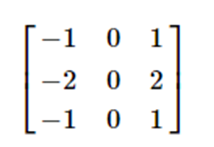
 
•	Bộ lọc Sobel 3x3, đạo hàm bậc 1 theo chiều y – dùng để lọc các cạnh ngang:

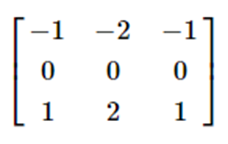
 
Việc tính toán Sobel được thực hiện với hàm `cv2.Sobel()` với các tham số chính như sau:

•	dx: bậc đạo hàm theo chiều x.
•	dy: bậc đạo hàm theo chiều y.
•	ksize: kích thước cửa sổ lọc. Các giá trị cho phép: 1, 3, 5, hoặc 7.
Các bạn xem thêm các tham số khác tại tài liệu chính thức của OpenCV: https://docs.opencv.org/4.5.4/d4/d86/group__imgproc__filter.html#gacea54f142e81b6758cb6f375ce782c8d. Sau đây là một ví dụ về việc sử dụng bộ lọc Sobel cho phát hiện cạnh.



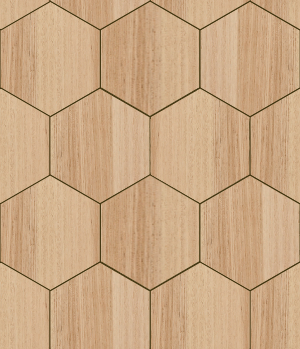

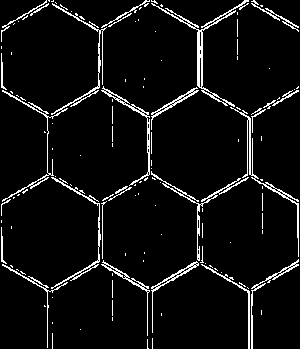

In [ ]:
# Đọc ảnh
img = cv2.imread('wood.png')

# Chuyển ảnh đã đọc sang ảnh xám
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Áp dụng bộ lọc Gaussian để loại bỏ bớt nhiễu.
# Các bạn có thể thử nghiệm các bộ lọc khác tại đây,
# như bộ lọc Median hoặc Bilateral.
img_gauss = cv2.GaussianBlur(gray, (5, 5), 0)

# Áp dụng Sobel để tìm cạnh dọc
sobel_ksize = 3
sobelx64f = cv2.Sobel(img_gauss, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
abs_sobel64f = np.absolute(sobelx64f)
img_sobelx = np.uint8(abs_sobel64f)

# Áp dụng Sobel để tìm cạnh ngang
sobely64f = cv2.Sobel(img_gauss, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
abs_sobel64f = np.absolute(sobely64f)
img_sobely = np.uint8(abs_sobel64f)

# Tính toán trung bình cạnh ngang - dọc
img_sobel = (img_sobelx + img_sobely) / 2

# Chuyển về ảnh nhị phân: Lọc ảnh để đặt các vùng có đạo hàm lớn - có sự chuyển
# đổi màu sắc mạnh về màu trắng (255 - là cạnh) và các vị trí nằm dưới ngưỡng
# về màu đen (0 - không phải cạnh)
threshold = 60
img_sobel[img_sobel < threshold] = 0
img_sobel[img_sobel >= threshold] = 255

# Hiện ảnh đầu vào và ảnh kết quả
cv2_imshow(img)
cv2_imshow(img_sobel)

Trong hình ảnh kết quả ta vẫn thấy các nhiễu. Các bạn có thể thử thay bộ lọc Gaussian bằng bộ lọc khác có khả năng lọc nhiễu tốt hơn và giữ lại tốt các đường biên trong ảnh.

## 7. Tìm cạnh trong ảnh: Bộ lọc / thuật toán Canny

Bộ lọc Canny là một bộ lọc rất mạnh mẽ trong thị giác máy tính, dùng cho mục đích phát hiện cạnh. Chúng ta có thể gọi bộ lọc này là thuật toán Canny, vì nó gồm nhiều bước:

-	Lấy đạo hàm của ảnh theo chiều ngang và dọc.
-	Tính cường độ và hướng của đạo hàm (gradient).
-	Kết hợp các kết quả để loại bỏ các pixel thừa (Non-maximum supression).
-	Sử dụng các ngưỡng lọc trên (high) và dưới (low) để đưa ra các kết quả cuối cùng: Các cạnh nằm dưới ngưỡng dưới chắc chắn bị loại bỏ. Các cạnh nằm trên ngưỡng trên được gọi là các cạnh mạnh. Các cạnh nằm giữa hai ngưỡng được gọi là cạnh yếu. Một cạnh yếu sẽ chỉ được giữ lại khi nó kết nối với ít nhất 1 cạnh mạnh.

Canny cũng được hỗ trợ sẵn trong OpenCV, giúp các bạn có thể dễ dàng sử dụng. Dưới đây là mã nguồn ví dụ của việc lọc cạnh với bộ lọc Canny.


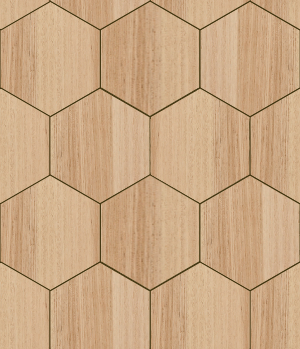

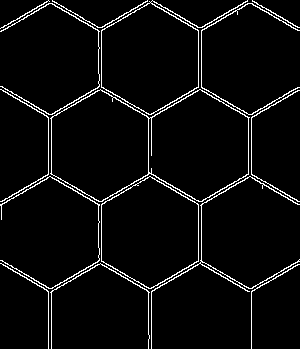

In [ ]:
# Đọc ảnh
img = cv2.imread('wood.png')

# Chuyển ảnh đã đọc sang ảnh xám
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Áp dụng bộ lọc Gaussian để loại bỏ bớt nhiễu.
# Các bạn có thể thử nghiệm các bộ lọc khác tại đây,
# như bộ lọc Median hoặc Bilateral.
img_gauss = cv2.GaussianBlur(gray, (5, 5), 0)

# Áp dụng bộ lọc Canny với 2 ngưỡng.
# Các bạn có thể điều chỉnh 2 ngưỡng này và xem sự thay đổi
# trong ảnh kết quả
thresh_low = 60
thresh_high = 180
img_canny = cv2.Canny(img_gauss, thresh_low, thresh_high)

# Hiện ảnh đầu vào và ảnh kết quả
cv2_imshow(img)
cv2_imshow(img_canny)